# Doubly Stochastic Approximation

A doubly stochastic matrix is a squared nonnegative matrix which every single row and every single column sum to one.  According to the Birkhoff-von Neumann theorem, DSMs form the Birkhoff polytope $\mathbb{B}^{n}$ which is a convex hull for the set of $n \times n$ permutation matrices. Consequently, it is natural to think of DSMs as relaxations of permutation matrices. In addition, DSMs are continuous which make them useful for gradient-based learners, differently from permutation matrices.


In [89]:
%matplotlib inline
import numpy as np
np.set_printoptions(precision=5, suppress=True)
import matplotlib.pyplot as plt
from cvxpy import *

## Problem

Therefore, **the goal of doubly stochastic approximation is to find the closest doubly stochastic matrix $Y \in \mathbb{B}^{n \times n}$ from a given arbritary square matrix $X \in \mathbb{R}^{n \times n}$**. We will use random matrices as Xs and introduce approximate and exact solutions for this problem. In order to measure the quality of the approximation, we will measure the average $\ell_1\text{-error}$ over rows and columns.


In [90]:
# l1-Error
def dsm_error(X):
    e_rows = np.abs(1. - np.sum(X, axis=1))
    e_cols = np.abs(1. - np.sum(X, axis=0))
    return np.mean(np.append(e_rows, e_cols))

# Random generated matrix
X = np.random.rand(4,4) * 10
print("Averaged DSM error for a random matrix: {:.2f}".format(dsm_error(X)))

Averaged DSM error for a random matrix: 20.07


### Sinkhorn Iterations

According to the Sinkhorn theorem, if $X$ is an $n \times n$ matrix with **strictly positive elements**, then there exist diagonal matrices $D_1$ and $D_2$ with strictly positive diagonal elements such that $D_1XD_2$ is doubly stochastic. In addition, Sinkhorn and Knopp introduced a simple iterative method to approach the double stochastic matrix by alternately rescaling all rows and all columns of $X$ to sum to 1. Therefore, a principled and efficient way to approximate DSMs is to make use of these theorems. 

In [95]:
def sinkhorn(X, max_it=10):
    Y = np.copy(X)
    for it in range(max_it):
        # Line multipliers normalizer
        D1 = np.diagflat(1. / np.sum(Y, axis=1))
        # Cols multipliers normalizer
        D2 = np.diagflat(1. / np.sum(np.dot(D1, Y), axis=0))
        # Normalize D1 Y D2
        Y = np.dot(np.dot(D1, Y),D2)
    return Y, D1, D2

X = np.random.rand(2,2)
Y, _, _ = sinkhorn(X)
print("Random input:\n{}".format(X))
print("Sinkhorn Approx. DSM:\n{}".format(Y))

Random input:
[[ 0.93816  0.31993]
 [ 0.04423  0.52943]]
Sinkhorn Approx. DSM:
[[ 0.85572  0.14454]
 [ 0.14428  0.85546]]


Let's do a better experiment: Create $NumTrials$ (e.g, 10) random matrix of size $n$, compute their approximated dsm using the sinkhorn algorithm, compute the approximation error and report a boxplot. Repeat this experiment for different matrices size (e.g, $n \in [2, 10]$). As we can see below, the Sinkhorn normalization just need 10 iterations to reach almost perfect approximations. In addition, larger matrices makes the convergence even better.    

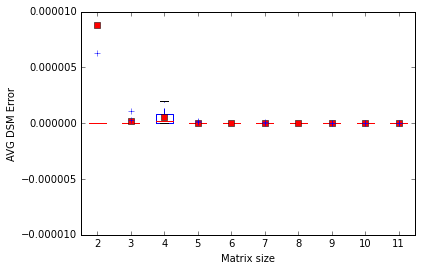

In [92]:
# Experiment
NumTrials, Nmax = 10, 10
errors = np.ones((NumTrials, Nmax), dtype=np.float)
for n in range(Nmax):
    for trial in range(NumTrials):
        X = np.random.rand(2+n, 2+n)
        Y, _, _ = sinkhorn(X, max_it=10)
        errors[trial, n] = dsm_error(Y)

# Boxplot of dsm errors 
plt.boxplot(errors, labels=range(2, 2+Nmax), showmeans=True)
plt.ylim([-1e-5,1e-5])
plt.ylabel('AVG DSM Error')
plt.xlabel('Matrix size')
plt.show()

### Exact Solution

The DSM approximation problem can be described as,
\begin{equation*}
\begin{aligned}
& \underset{Y \in \mathbb{R_+}^{n \times n}}{\text{minimize}}
& & \mid\mid Y - X \mid\mid_F \\
& \text{subject to}
& & \mathbf{1^T} Y = \mathbf{1} \\
& & & Y \mathbf{1} = \mathbf{1} \\
\end{aligned}
\end{equation*}
where $\mathbf{1}$ is a column vector of ones. This problem is convex and can be easily stated as a quadratic program by vectorizing the matrices and performing the change of variavle $z = vec(Y) - vec(x)$. However, we will let  

In [93]:
# DSM approx. as QP
def dsm_qp(X):
    Y = Variable(*X.shape)
    obj = Minimize(norm(Y - X, 'fro'))
    consts = [sum_entries(Y, axis=0) == 1, sum_entries(Y, axis=1) == 1, Y >= 0]
    prob = Problem(obj, consts)
    prob.solve()
    return Y.value, prob.value

X = np.random.rand(3,3)
Y, _ = dsm_qp(X)
print("Random input:\n{}".format(X))
print("Best Approx. DSM:\n{}".format(Y))                                                      

Random input:
[[ 0.74256  0.18086  0.66062]
 [ 0.2361   0.75894  0.68974]
 [ 0.33575  0.11498  0.79574]]
Best Approx. DSM:
[[ 0.61144  0.13629  0.25227]
 [ 0.0714   0.68079  0.24781]
 [ 0.31716  0.18293  0.49992]]


If the problem is feasible, then the solution is the closest DSM to the given arbritary matrix. Different from the Sinkhorn approach, this method does not require any special structure in the input matrix, it can even have negative entries. However, it may be more computationally expensive than the Sinkhorn approach for large matrices.

As a final experiment, let's se how far the Sinkhorn solutions are from optimum. We create $NumTrials$ (e.g., 10) random matrices of size $n$, find the approximated dsm by both methods, compute the forbenius norm between them and report the box plot of these values. We repeat this experiment for $n \in [2, 10]$. Note the Sinkhorn solutions become far from the optimum as the input matrix size $n$ increases.

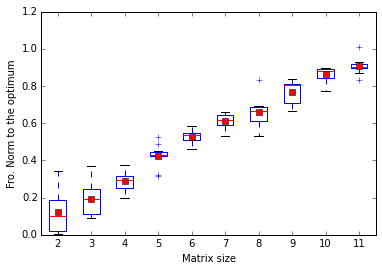

In [94]:
NumTrials, Nmax = 10, 10
fro_dist = np.ones((NumTrials, Nmax), dtype=np.float)
for n in range(Nmax):
    for trial in range(NumTrials):
        X = np.random.rand(2+n, 2+n)
        Y_sk, _, _ = sinkhorn(X, max_it=10)
        Y_qp, _ = dsm_qp(X)
        fro_dist[trial, n] = np.linalg.norm(Y_qp - Y_sk, ord='fro')
        
# Boxplot of opt dist
plt.boxplot(fro_dist, labels=range(2, 2+Nmax), showmeans=True)
plt.ylabel('Fro. Norm to the optimum')
plt.xlabel('Matrix size')
plt.show()